In [1]:
import requests
from io import BytesIO
import pandas as pd
import arcgis
from arcgis.features import FeatureLayer
from arcgis.mapping import WebMap
from arcgis.gis import GIS

/Users/bonnie/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/_data/geodataset/utils.py:16: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime,


In [15]:
def gis_login(client_id):
    '''Takes a string of client_id, directs to the login page.
    users need to copy and paste the access code to the output prompt.
    Prints the userid after successful login. 
    '''
    gis = GIS("https://utoronto.maps.arcgis.com",client_id=client_id)
    print("Successfully logged in as: " + gis.properties.user.username)
    return gis

In [17]:
gis = gis_login("5EmEaEGg3vW2nyAl")

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://utoronto.maps.arcgis.com/sharing/rest/oauth2/authorize?client_id=5EmEaEGg3vW2nyAl&response_type=code&expiration=-1&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob
Enter code obtained on signing in using SAML: ········
Successfully logged in as: yangyu47_utoronto


<Item title:"Coronavirus COVID-19 (2019-nCoV)" type:Dashboard owner:CSSE_covid19>
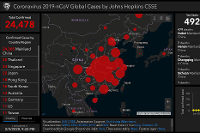

In [18]:
item = gis.content.search("Coronavirus_2019_nCoV_Cases owner:CSSE_covid19", outside_org=True)[0]
item

In [20]:
#Query the source feature layer
src_url = "https://services1.arcgis.com/0MSEUqKaxRlEPj5g/arcgis/rest/services/Coronavirus_2019_nCoV_Cases/FeatureServer/1"
fl = FeatureLayer(url=src_url)
df_global = fl.query(where="1=1",
                     return_geometry=True,
                     as_df=True)
#generate a global dataframe with a total number of confirmed, recovered, and deaths cases
df_global[~pd.isnull(df_global['Province_State'])].groupby('Country_Region').sum()[['Confirmed', 'Recovered', 'Deaths']]

/Users/bonnie/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/layer.py:1423: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  "esriFieldTypeDate" : pd.datetime,


,Confirmed,Recovered,Deaths
Country_Region,,,
Australia,61609,0,1039
Belgium,1192008,0,25397
Brazil,20877864,0,583362
Canada,1521357,0,27069
Chile,1640666,0,37067
China,107194,0,4848
Colombia,4916980,0,125230
Denmark,1355,0,2
France,234655,0,2227


<Item title:"Provinces and Territories of Canada" type:Feature Layer Collection owner:esri_canada>
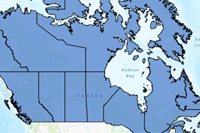

In [21]:
# Query the reference feature layer of Canada
ca_province_item = gis.content.get('d3fef65386df4e63b02d6e23bb98a1ee')
ca_province_item

In [22]:
provinces_flayer = ca_province_item.layers[0]
provinces_df = provinces_flayer.query(as_df=True)
provinces_df.columns

/Users/bonnie/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/layer.py:1423: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  "esriFieldTypeDate" : pd.datetime,


Index(['FID', 'OBJECTID', 'type', 'type_en', 'postal', 'Shape_Leng',
       'Shape_Area', 'Name_EN', 'Nom_Fr', 'SHAPE'],
      dtype='object')

In [23]:
tmp = provinces_df.sort_values('Name_EN', ascending=True)
provinces_df = tmp.drop_duplicates(subset='Name_EN', keep='last')
provinces_df.shape

(13, 10)

In [24]:
# DataFrame Merging for Canada Dataset
df_canada = fl.query(where="Country_Region='Canada'",as_df=True)
df_canada = df_canada[['Province_State', 'Confirmed', 'Recovered', 'Deaths']]
df_canada = df_canada.assign(Name_EN = df_canada["Province_State"])
df_canada.head()

,Province_State,Confirmed,Recovered,Deaths,Name_EN
0,Alberta,256985,0,2390,Alberta
1,British Columbia,168325,0,1827,British Columbia
2,Diamond Princess,0,0,1,Diamond Princess
3,Grand Princess,13,0,0,Grand Princess
4,Manitoba,58845,0,1192,Manitoba


In [25]:
cols_2 = ['Name_EN', 'Shape_Area', 'Shape_Leng','SHAPE','type','postal']
overlap_rows_canada = pd.merge(left = provinces_df[cols_2], right = df_canada, 
                              how='inner', on = 'Name_EN')
overlap_rows_canada.head()

,Name_EN,Shape_Area,Shape_Leng,SHAPE,type,postal,Province_State,Confirmed,Recovered,Deaths
0,Alberta,2.046155e+12,6.480084e+06,"{'rings': [[[-12245068.4111107, 6273608.898894...",Province,AB,Alberta,256985,0,2390
1,British Columbia,2.864108e+12,2.995914e+07,"{'rings': [[[-13718912.1255787, 6177039.990696...",Province,BC,British Columbia,168325,0,1827
2,Manitoba,1.987391e+12,7.174885e+06,"{'rings': [[[-9901534.70535117, 7730176.501052...",Province,MB,Manitoba,58845,0,1192
3,New Brunswick,1.541619e+11,3.044798e+06,"{'rings': [[[-7432741.51518457, 5589409.025508...",Province,NB,New Brunswick,2798,0,46
4,Newfoundland and Labrador,1.113019e+12,2.939165e+07,"{'rings': [[[-6100127.70123468, 5981762.739132...",Province,NL,Newfoundland and Labrador,1491,0,7


<Item title:"Australia State Boundaries 2020" type:Feature Layer Collection owner:esri_dm>
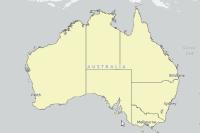

In [26]:
# Query the reference feature layer of Australia
aus_states_item = gis.content.get('1eb0511ee53a47b386e98e9c4663127b')
aus_states_item

In [27]:
aus_states_flayer = aus_states_item.layers[2]
aus_states_df = aus_states_flayer.query(as_df=True)
aus_states_df.columns

/Users/bonnie/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/layer.py:1423: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  "esriFieldTypeDate" : pd.datetime,


Index(['OBJECTID', 'ID', 'NAME', 'AREA', 'TOTPOP_CY', 'ISO_CODE', 'ISO_SUB',
       'ISO2_CC', 'ISO3_CC', 'Shape__Area', 'Shape__Length', 'SHAPE'],
      dtype='object')

In [29]:
aus_states_df

,OBJECTID,ID,NAME,AREA,TOTPOP_CY,ISO_CODE,ISO_SUB,ISO2_CC,ISO3_CC,Shape__Area,Shape__Length,SHAPE
0,1,1,New South Wales,8.008455e+05,8129009,AUNSW,NSW,AU,AUS,1.122920e+12,9.644242e+06,"{'rings': [[[16703645.1077, -4475853.0507], [1..."
1,2,2,Victoria,2.274952e+05,6644802,AUVIC,VIC,AU,AUS,3.561376e+11,6.324012e+06,"{'rings': [[[16285504.4721, -4744453.0384], [1..."
2,3,3,Queensland,1.730168e+06,5129791,AUQLD,QLD,AU,AUS,2.050544e+12,1.710215e+07,"{'rings': [[[17077774.7245, -3240314.4403], [1..."
3,4,4,South Australia,9.842817e+05,1756079,AUSA,SA,AU,AUS,1.323554e+12,9.970571e+06,"{'rings': [[[15658300.314, -4588263.1137], [15..."
4,5,5,Western Australia,2.526646e+06,2629391,AUWA,WA,AU,AUS,3.140951e+12,2.588493e+07,"{'rings': [[[13121168.2698, -4189066.211], [13..."
5,6,6,Tasmania,6.801757e+04,536606,AUTAS,TAS,AU,AUS,1.230496e+11,9.792041e+06,"{'rings': [[[16294077.1742, -5425368.5557], [1..."
6,7,7,Northern Territory,1.348088e+06,244543,AUNT,NT,AU,AUS,1.531500e+12,1.371298e+07,"{'rings': [[[15259049.6029, -1788024.0168], [1..."
7,8,8,Australian Capital Territory,2.358196e+03,429263,AUACT,ACT,AU,AUS,3.564915e+09,3.760147e+05,"{'rings': [[[16600879.9624, -4181065.9785], [1..."
8,9,9,Other Territories,6.781356e+01,397,AUACT,ACT,AU,AUS,1.016708e+08,8.228954e+04,"{'rings': [[[16775280.3133, -4188899.7713], [1..."


In [28]:
fset_aus = fl.query(where="Country_Region='Australia'")
fset_aus

<FeatureSet> 8 features

In [30]:
# DataFrame Merging for Australia Dataset
df_aus = fset_aus.sdf[['Province_State', 'Confirmed', 'Recovered', 'Deaths']]
df_aus = df_aus.assign(NAME = df_aus["Province_State"])
df_aus.head()

,Province_State,Confirmed,Recovered,Deaths,NAME
0,Australian Capital Territory,498,0,3,Australian Capital Territory
1,New South Wales,33782,0,180,New South Wales
2,Northern Territory,202,0,0,Northern Territory
3,Queensland,1984,0,7,Queensland
4,South Australia,880,0,4,South Australia


In [31]:
cols_4 = ['NAME', 'AREA', 'TOTPOP_CY','SHAPE','Shape__Area','Shape__Length','ISO_CODE']
overlap_rows_aus = pd.merge(left = aus_states_df[cols_4], right = df_aus, 
                              how='inner', on = 'NAME')
overlap_rows_aus.head()

,NAME,AREA,TOTPOP_CY,SHAPE,Shape__Area,Shape__Length,ISO_CODE,Province_State,Confirmed,Recovered,Deaths
0,New South Wales,8.008455e+05,8129009,"{'rings': [[[16703645.1077, -4475853.0507], [1...",1.122920e+12,9.644242e+06,AUNSW,New South Wales,33782,0,180
1,Victoria,2.274952e+05,6644802,"{'rings': [[[16285504.4721, -4744453.0384], [1...",3.561376e+11,6.324012e+06,AUVIC,Victoria,22942,0,823
2,Queensland,1.730168e+06,5129791,"{'rings': [[[17077774.7245, -3240314.4403], [1...",2.050544e+12,1.710215e+07,AUQLD,Queensland,1984,0,7
3,South Australia,9.842817e+05,1756079,"{'rings': [[[15658300.314, -4588263.1137], [15...",1.323554e+12,9.970571e+06,AUSA,South Australia,880,0,4
4,Western Australia,2.526646e+06,2629391,"{'rings': [[[13121168.2698, -4189066.211], [13...",3.140951e+12,2.588493e+07,AUWA,Western Australia,1086,0,9


Create a function to generate maps for confirmed cases for any countries analyzed above

In [32]:
def func1(country, overlap_rows_country):
    '''Takes in a string of country name - first letter to be a capital letter, 
    and a corresponding dataframe created earlier,
    returns the maps of confirmed cases in points, in polygons and a webmap'''
    map0 = gis.map(country, zoomlevel=4)
    map0.add_layer(fl, { "type": "FeatureLayer",
                     "renderer":"ClassedSizeRenderer",
                     "field_name": "Confirmed"})
    map0.zoom = 3
    map0.legend = True
    map0b = gis.map(country)
    map0b.clear_graphics()
    overlap_rows_country.spatial.plot(kind='map', map_widget=map0b,
                                  renderer_type='c',  # for class breaks renderer
                                  method='esriClassifyNaturalBreaks',  # classification algorithm
                                  class_count=4,  # choose the number of classes
                                  col= 'Confirmed',  # numeric column to classify
                                  cmap='inferno',  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
    map0b.zoom = 4
    map0b.legend = True
    result = map0b.save({'title': 'Confirmed COVID-19 Cases in ' + str(country),
            'snippet':'Map created using Python API showing confirmed COVID-19 cases in '+ str(country),
            'tags':['automation', 'COVID19', 'world health', 'python']})
    return map0, map0b, result

In [33]:
#Test
func1('Canada', overlap_rows_canada)

/Users/bonnie/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/geo/_accessor.py:2206: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime)):


(MapView(layout=Layout(height='400px', width='100%'), legend=True, zoom=3.0),
 MapView(layout=Layout(height='400px', width='100%'), legend=True, zoom=4.0),
 <Item title:"Confirmed COVID-19 Cases in Canada" type:Web Map owner:yangyu47_utoronto>)

Create a function to generate maps for recovered cases for any countries analyzed above

In [34]:
def func2(country, overlap_rows_country):
    '''Takes in a string of country name - first letter to be capital, 
    and a corresponding dataframe created earlier,
    returns the maps of recovered cases in points, in polygons and a webmap'''
    map0 = gis.map(country, zoomlevel=4)
    map0.add_layer(fl, { "type": "FeatureLayer",
                     "renderer":"ClassedSizeRenderer",
                     "field_name": "Recovered"})
    map0.zoom = 3
    map0.legend = True
    map0b = gis.map(country)
    map0b.clear_graphics()
    overlap_rows_country.spatial.plot(kind='map', map_widget=map0b,
                                  renderer_type='c',  # for class breaks renderer
                                  method='esriClassifyNaturalBreaks',  # classification algorithm
                                  class_count=4,  # choose the number of classes
                                  col= 'Recovered',  # numeric column to classify
                                  cmap='inferno',  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
    map0b.zoom = 4
    map0b.legend = True
    result = map0b.save({'title': 'Recovered COVID-19 Cases in ' + country,
            'snippet':'Map created using Python API showing recovered COVID-19 cases in '+ country,
            'tags':['automation', 'COVID19', 'world health', 'python']})
    return map0, map0b, result

In [36]:
#Test
func2('Australia', overlap_rows_aus)

/Users/bonnie/opt/anaconda3/lib/python3.7/site-packages/arcgis/features/geo/_accessor.py:2206: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  pd.datetime)):


(MapView(layout=Layout(height='400px', width='100%'), legend=True, zoom=3.0),
 MapView(layout=Layout(height='400px', width='100%'), legend=True, zoom=4.0),
 <Item title:"Recovered COVID-19 Cases in Australia" type:Web Map owner:yangyu47_utoronto>)

Create a function to generate maps for deaths cases for any countries analyzed above

In [35]:
def func3(country, overlap_rows_country):
    '''Takes in a string of country name - first letter to be capital, 
    and a corresponding dataframe created earlier,
    returns the maps of deaths cases in points, in polygons and a webmap'''
    map0 = gis.map(country, zoomlevel=4)
    map0.add_layer(fl, { "type": "FeatureLayer",
                     "renderer":"ClassedSizeRenderer",
                     "field_name": "Deaths"})
    map0.zoom = 3
    map0.legend = True
    map0b = gis.map(country)
    map0b.clear_graphics()
    overlap_rows_country.spatial.plot(kind='map', map_widget=map0b,
                                  renderer_type='c',  # for class breaks renderer
                                  method='esriClassifyNaturalBreaks',  # classification algorithm
                                  class_count=4,  # choose the number of classes
                                  col= 'Recovered',  # numeric column to classify
                                  cmap='inferno',  # color map to pick colors from for each class
                                  alpha=0.7  # specify opacity
                                 )
    map0b.zoom = 4
    map0b.legend = True
    result = map0b.save({'title': 'Deaths COVID-19 Cases in ' + str(country),
            'snippet':'Map created using Python API showing deaths COVID-19 cases in '+ str(country),
           'tags':['automation', 'COVID19', 'world health', 'python']})
    return map0, map0b,result

In [37]:
#Test
func3('Canada', overlap_rows_canada)

(MapView(layout=Layout(height='400px', width='100%'), legend=True, zoom=3.0),
 MapView(layout=Layout(height='400px', width='100%'), legend=True, zoom=4.0),
 <Item title:"Deaths COVID-19 Cases in Canada" type:Web Map owner:yangyu47_utoronto>)